### Daytum: Course: Data Analytics, Geostatistics and Machine Learning Deep Dive

### Clustering Demonstration and Exercise


#### Goal

Clustering for multivariate statistical inference.

#### Description

Here's a simple, documented workflow, demonstration of clsutering statistical inference for subsurface modeling workflows. This should help you get started with segmenting (e.g. facies) subsurface datasets with large numbers of features. 

Here's a simple workflow, demonstration of K-means clustering for subsurface modeling workflows. This should help you get started with inferential methods to find patterns in your subsurface data sets.  

This workflow is broken up to the primary steps of:

* assign initial random prototype with labels

* assign samples to the nearest prototype label

* update prototype based on centroids of samples belonging to this prototype

* iterate until no sample assignments change

This allows us to be able to watch the method in action, as opposed to just getting a result.  I think this is more instructive.

For this workflow I have modified code from the tutorial provided by Ben Keen as functions to take care of the steps (assign training data to the nearest prototype, update the prototype to the centroid of the assigned data).  The original tutorial is avaiable at [here](http://benalexkeen.com/k-means-clustering-in-python). All I did was specify the method to my data example for clarity, and include the normalized and original data. Appreciation to Ben!

#### k-Means Clustering

The K-means clustering approach is primaryly applied as an unsupervised method for classification:

* **Prototype Method** - represents the training data with number of synthetic cases in the features space. For K-means clustering we assign and iteratively update $K$ prototypes.

* **Iterative Solution** - the initial prototypes are assigned randomly in the feature space, the labels for each training sample are updated to the nearest prototype, then the prototypes are adjusted to the centroid of their assigned training data, repeat until there is no further update to the training data assignments.

* **Unsupervised Learning** - the training data are not labeled and are assigned $K$ labels based on their proximity to the prototypes in the feature space.  The idea is that similar things, proximity in feature space, should belong to the same category.  

* **Feature Weighting** - the procedure depends on the 'distance' between training samples and prototypes in feature space.  Distance is treated as the 'inverse' of similarity. If the features have significantly different magnitudes, the feature(s) with the largest magnitudes and ranges will dominate the process.  One approach is to sandardize / normalize the variables.  Also, by-feature weighting may be applied.  In this demonstration we normalize the features to range from 0.0 to 1.0.

* Supervised Learning Variant for Classification of the Feature Space - applies multiple prototypes in each category to then constructs a decision boundary based on nearest prototype.  More prototypes per category results in a more complicated decision boundary in the feature space.  

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import copy                               # for deep copies

#### Declare Functions

The following functions perform the steps required by K-means clustering.

* assign the training data to the nearest prototype

* update the prototype to the centroid of the assigned training data

Don't be concerned if you don't understand the code, we have used some advanced approaches for the benefit of concise code.

In [3]:
# Assignment function to assigned training data to the nearest prototype (code modified from Ben Keen, http://benalexkeen.com/k-means-clustering-in-python/)
def assignment(df, centroids):
    for i in centroids.keys():
        df['distance_from_{}'.format(i)] = (    # use the normalized features and centroids
            np.sqrt(
                (df['Norm_Porosity'] - centroids[i][2]) ** 2
                + (df['Norm_AI'] - centroids[i][3]) ** 2
            )
        )
    centroid_distance_cols = ['distance_from_{}'.format(i) for i in centroids.keys()]
    df['closest'] = df.loc[:, centroid_distance_cols].idxmin(axis=1)
    df['closest'] = df['closest'].map(lambda x: int(x.lstrip('distance_from_')))
    df['color'] = df['closest'].map(lambda x: colmap[x])
    return df

# Update function to shift the prototype to the centroid of the training data assigned to the prototype (code modified from Ben Keen, http://benalexkeen.com/k-means-clustering-in-python/)
def update(k,pormin,pormax,AImin,AImax):
    for i in centroids.keys():
        centroids[i][2] = np.mean(df[df['closest'] == i]['Norm_Porosity'])
        centroids[i][3] = np.mean(df[df['closest'] == i]['Norm_AI'])
        centroids[i][0] = centroids[i][2] * (pormax-pormin) + pormin
        centroids[i][1] = centroids[i][3] * (AImax-AImin) + AImin
    return k

#### Loading Data
Let's load the provided multivariate, spatial dataset.  It is a DataFrame with: 

* X and Y coordinates ($m$)
* facies 0 and 1 
* porosity (fraction)
* permeability ($mD$)
* acoustic impedance ($\frac{kg}{m^3} \cdot \frac{m}{s} \cdot 10^3$). 

Let's load the data and run this command to load the data and then this command to extract a random subset of the data.

```python
df = df.sample(frac=.30, random_state = 73073); 
df = df.reset_index()
```

We do this to reduce the number of data for ease of visualization (hard to see if too many points on our plots).

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/daytum/intake-data/refs/heads/master/daytum_cat/data/sample_data_12.csv')
df = df.sample(frac=.30, random_state = 73073); df = df.reset_index() # extract 30% random to reduce the number of data

#### Summary Statistics for Tabular Data

The table includes porosity (fraction) and acoustic impedance ($\frac{kg}{m^3} \cdot \frac{m}{s} \cdot 10^3$) that we will work with in the demonstration below.

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,144.0,261.048611,136.830267,1.000000,144.750000,270.000000,381.250000,478.000000
Unnamed: 0,144.0,440.291667,245.046303,2.000000,217.250000,459.000000,659.250000,825.000000
X,144.0,449.375000,263.691435,0.000000,242.500000,400.000000,650.000000,980.000000
Y,144.0,542.979167,289.228936,19.000000,300.000000,579.000000,800.000000,979.000000
Facies,144.0,0.659722,0.475456,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,144.0,0.190700,0.031972,0.131230,0.166621,0.188733,0.217234,0.256172
Perm,144.0,510.036736,1136.459068,0.039555,6.950509,56.886770,356.658709,7452.343369
AI,144.0,3746.825725,793.196589,1961.600397,3167.631744,3668.526774,4244.264532,6194.573653


The two features are quite incompatible.  They have dramatically different:

* magnitudes / averages

* variances / ranges

We should make a normalized version of each.  We will scale the variables to range from 0 to 1.  

* There is no distribution shape change.

We will use these normalized values for calculating distance in our workflow:

* to remove the influence of magnitude and range on our similarity calculation

In [6]:
pormin = df['Porosity'].min(); pormax = df['Porosity'].max()
AImin = df['AI'].min(); AImax = df['AI'].max()

df['Norm_Porosity'] = (df['Porosity']-pormin)/(pormax - pormin)
df['Norm_AI'] = (df['AI']-AImin)/(AImax - AImin)

Let's confirm that our normalized porosity and acoustic impedance now range between 0 and 1.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,144.0,261.048611,136.830267,1.000000,144.750000,270.000000,381.250000,478.000000
Unnamed: 0,144.0,440.291667,245.046303,2.000000,217.250000,459.000000,659.250000,825.000000
X,144.0,449.375000,263.691435,0.000000,242.500000,400.000000,650.000000,980.000000
Y,144.0,542.979167,289.228936,19.000000,300.000000,579.000000,800.000000,979.000000
Facies,144.0,0.659722,0.475456,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,144.0,0.190700,0.031972,0.131230,0.166621,0.188733,0.217234,0.256172
Perm,144.0,510.036736,1136.459068,0.039555,6.950509,56.886770,356.658709,7452.343369
AI,144.0,3746.825725,793.196589,1961.600397,3167.631744,3668.526774,4244.264532,6194.573653
Norm_Porosity,144.0,0.475986,0.255894,0.000000,0.283258,0.460240,0.688350,1.000000
Norm_AI,144.0,0.421743,0.187385,0.000000,0.284914,0.403245,0.539258,1.000000


Now let's extract the porosity and acoustic impedance features and then look at the resulting DataFrame to ensure that we loaded and reformatted as expected. 

In [8]:
df_subset = df.iloc[:,[4,6,7,8]]              # extract Porosity and AI for a simple 2D example
df_subset.head()                          # preview the new DataFrame

,Facies,Perm,AI,Norm_Porosity
0,0.0,0.347182,4747.274043,0.067289
1,0.0,10.720560,4535.625583,0.316164
2,1.0,3222.716042,2696.102930,0.905345
3,0.0,3.042590,5500.997419,0.287294
4,1.0,400.298484,3959.934912,0.680501


#### Some Parameters

From the summary statistics we can assign a reasonable minimum and maximum for each feature.  

* We will use this for plotting.

We will also set the random number seed to ensure that the program does the same thing everytime it is run.

* Change the seed number for a different result

We will set the number of prototypes / clusters, *K*

We define a dictionary with the color code for each cluster, $k = 1,\ldots,K$.  Given 7 codes currently, there will be an error if $K$ is set larger than 7.  Add more color codes to the dictionary to allow for mor categories.

In [9]:
por_min = 0.12; por_max = 0.28
AI_min = 1500; AI_max = 6500
np.random.seed(210)
K = 7                                     # number of prototypes
colmap = {1: 'r', 2: 'g', 3: 'b', 4: 'm', 5: 'c', 6: 'k', 7: 'w'}

#### Visualization of Training Data

In this exercise, we want to use K-means clustering provide facies based on acoustic impedance and porosity predictor features. 

* This allows use to group rock with similar petrophysical and geophysical properties.

Let's start by looking at the scatterplot of our training data features, porosity and acoustic impedance.  

* We will look at the data in original units and normalized units through this entire exercise.

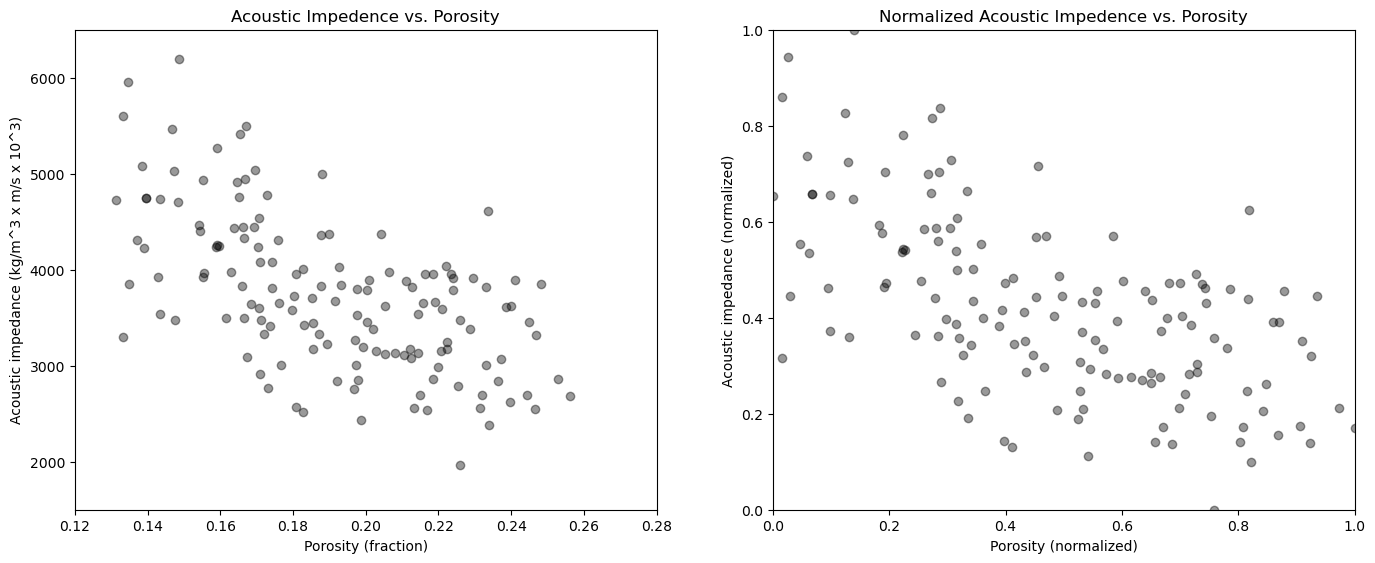

In [10]:
# scatter plot our training data  
plt.subplot(121)
plt.scatter(df['Porosity'], df['AI'], c="black", alpha = 0.4, linewidths=1.0, edgecolors="black")
plt.title('Acoustic Impedence vs. Porosity'); plt.xlabel('Porosity (fraction)'); plt.ylabel('Acoustic impedance (kg/m^3 x m/s x 10^3)')
plt.xlim(por_min, por_max)
plt.ylim(AI_min, AI_max)

plt.subplot(122)
plt.scatter(df_subset['Norm_Porosity'], df['Norm_AI'], c="black", alpha = 0.4, linewidths=1.0, edgecolors="black")
plt.title('Normalized Acoustic Impedence vs. Porosity'); plt.xlabel('Porosity (normalized)'); plt.ylabel('Acoustic impedance (normalized)')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

#### Initialize K Prototypes

First we will assign K prototypes in the feature space randomly.

* for K prototypes assign a random porosity and acoustic impedance

* don't worry, these prototypes won't make much sense initially, but they will improve

We will do this and then visualize the prototypes as red, green, blue etc. dots.

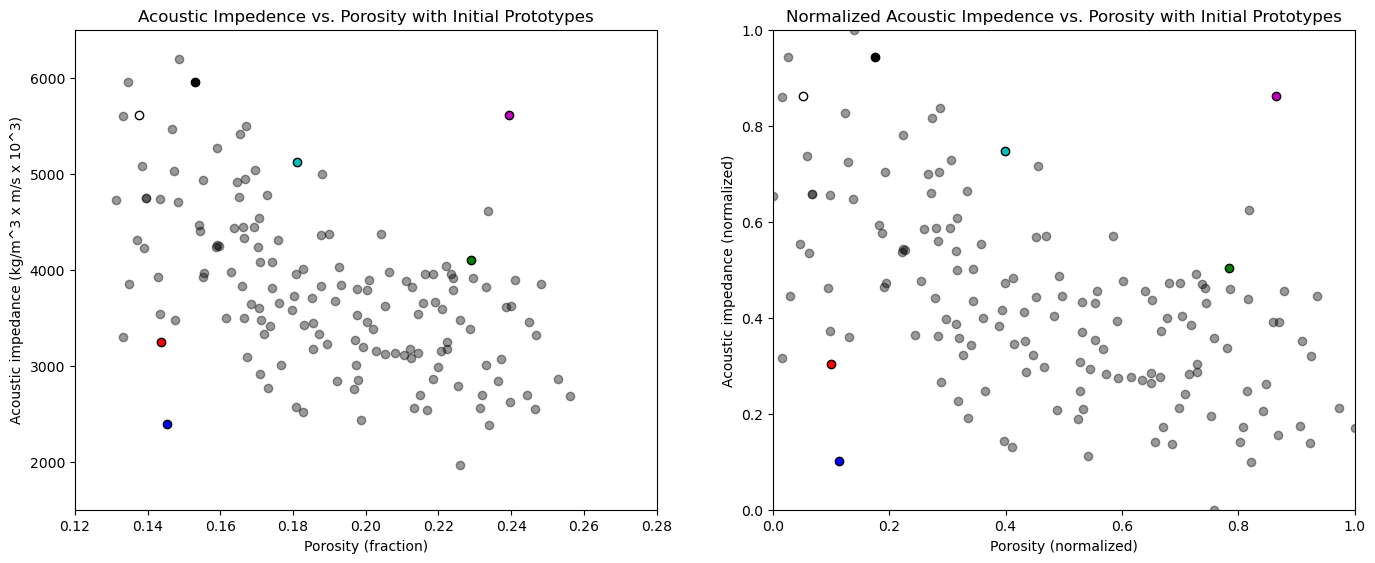

In [11]:
# Assign Initial Prototypes 
centroids = {}
for i in range(K):
    norm_por = np.random.random(); por = norm_por * (pormax-pormin) + pormin
    norm_AI = np.random.random(); AI = norm_AI * (AImax-AImin) + AImin
    centroids[i+1] = [por,AI,norm_por,norm_AI]
    
plt.subplot(121)                          # plot the training data and K prototypes
plt.scatter(df['Porosity'], df['AI'], c="black", alpha = 0.4, linewidths=1.0, edgecolors="black")
for i in centroids.keys():
    plt.scatter(centroids.get(i)[0], centroids.get(i)[1], color=colmap[i],linewidths=1.0, edgecolors="black")
plt.title('Acoustic Impedence vs. Porosity with Initial Prototypes'); plt.xlabel('Porosity (fraction)'); plt.ylabel('Acoustic impedance (kg/m^3 x m/s x 10^3)')
plt.xlim(por_min, por_max)
plt.ylim(AI_min, AI_max)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2)

plt.subplot(122)                          # plot the training data and K prototypes
plt.scatter(df_subset['Norm_Porosity'], df['Norm_AI'], c="black", alpha = 0.4, linewidths=1.0, edgecolors="black")
for i in centroids.keys():
    plt.scatter(centroids.get(i)[2], centroids.get(i)[3], color=colmap[i],linewidths=1.0, edgecolors="black")
plt.title('Normalized Acoustic Impedence vs. Porosity with Initial Prototypes'); plt.xlabel('Porosity (normalized)'); plt.ylabel('Acoustic impedance (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

#### Assignment of Training Data

All training data are assigned to the nearest prototype.  

* recall we have a function to do this

```python
df = assignment(df, centroids) 
```

* we work with the normalized features and visualize normalized and original features

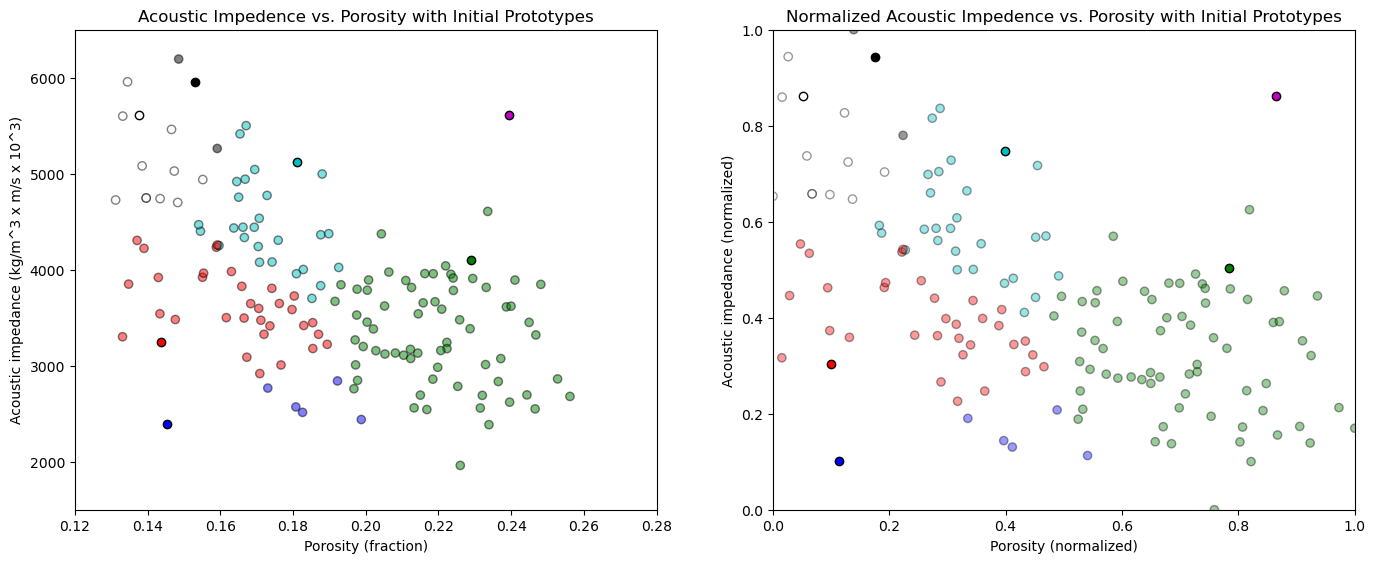

In [12]:
df = assignment(df, centroids)            # assign training data to the nearest prototype

plt.subplot(121)                          # plot the assigned training data and K prototypes
plt.scatter(df['Porosity'], df['AI'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(centroids.get(i)[0], centroids.get(i)[1], color=colmap[i],linewidths=1.0, edgecolors="black")
plt.title('Acoustic Impedence vs. Porosity with Initial Prototypes'); plt.xlabel('Porosity (fraction)'); plt.ylabel('Acoustic impedance (kg/m^3 x m/s x 10^3)')
plt.xlim(por_min, por_max)
plt.ylim(AI_min, AI_max)

plt.subplot(122)                          # plot the training data and K prototypes
plt.scatter(df_subset['Norm_Porosity'], df['Norm_AI'], c=df['color'], alpha = 0.4, linewidths=1.0, edgecolors="black")
for i in centroids.keys():
    plt.scatter(centroids.get(i)[2], centroids.get(i)[3], color=colmap[i],linewidths=1.0, edgecolors="black")
plt.title('Normalized Acoustic Impedence vs. Porosity with Initial Prototypes'); plt.xlabel('Porosity (normalized)'); plt.ylabel('Acoustic impedance (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

#### Update the Prototypes

Now we reassign the prototypes to the centroids of the training data belonging to each.

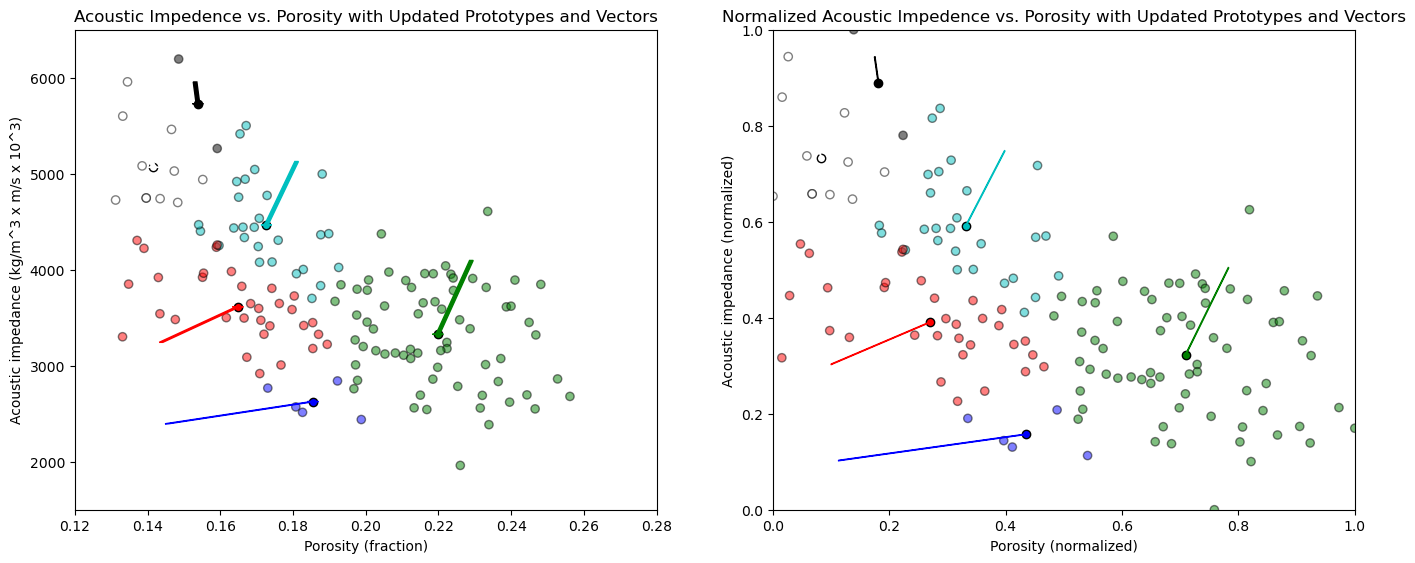

In [13]:
old_centroids = copy.deepcopy(centroids)
centroids = update(centroids,pormin,pormax,AImin,AImax)
    
plt.subplot(121)                          # plot the assigned training data and K prototypes
ax = plt.gca()
plt.scatter(df['Porosity'], df['AI'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(centroids.get(i)[0], centroids.get(i)[1], color=colmap[i],linewidths=1.0, edgecolors="black")
plt.title('Acoustic Impedence vs. Porosity with Updated Prototypes and Vectors'); plt.xlabel('Porosity (fraction)'); plt.ylabel('Acoustic impedance (kg/m^3 x m/s x 10^3)')
plt.xlim(por_min, por_max)
plt.ylim(AI_min, AI_max)

for i in old_centroids.keys():
    old_x = old_centroids[i][0]
    old_y = old_centroids[i][1]
    dx = (centroids[i][0] - old_centroids[i][0]) 
    dy = (centroids[i][1] - old_centroids[i][1]) 
    ax.arrow(old_x, old_y, dx, dy,fc=colmap[i], ec=colmap[i])
    
plt.subplot(122)                          # plot the assigned training data and K prototypes
ax = plt.gca()
plt.scatter(df['Norm_Porosity'], df['Norm_AI'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(centroids.get(i)[2], centroids.get(i)[3], color=colmap[i],linewidths=1.0, edgecolors="black")
plt.title('Normalized Acoustic Impedence vs. Porosity with Updated Prototypes and Vectors'); plt.xlabel('Porosity (normalized)'); plt.ylabel('Acoustic impedance (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)

for i in old_centroids.keys():
    old_x = old_centroids[i][2]
    old_y = old_centroids[i][3]
    dx = (centroids[i][2] - old_centroids[i][2]) 
    dy = (centroids[i][3] - old_centroids[i][3]) 
    ax.arrow(old_x, old_y, dx, dy,fc=colmap[i], ec=colmap[i])
      
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

#### Repeat the Assignment of the Training Data

Once again we assign the training data to the nearest prototype. 

* Note the prototypes were updated in the previous step so the assignments may change

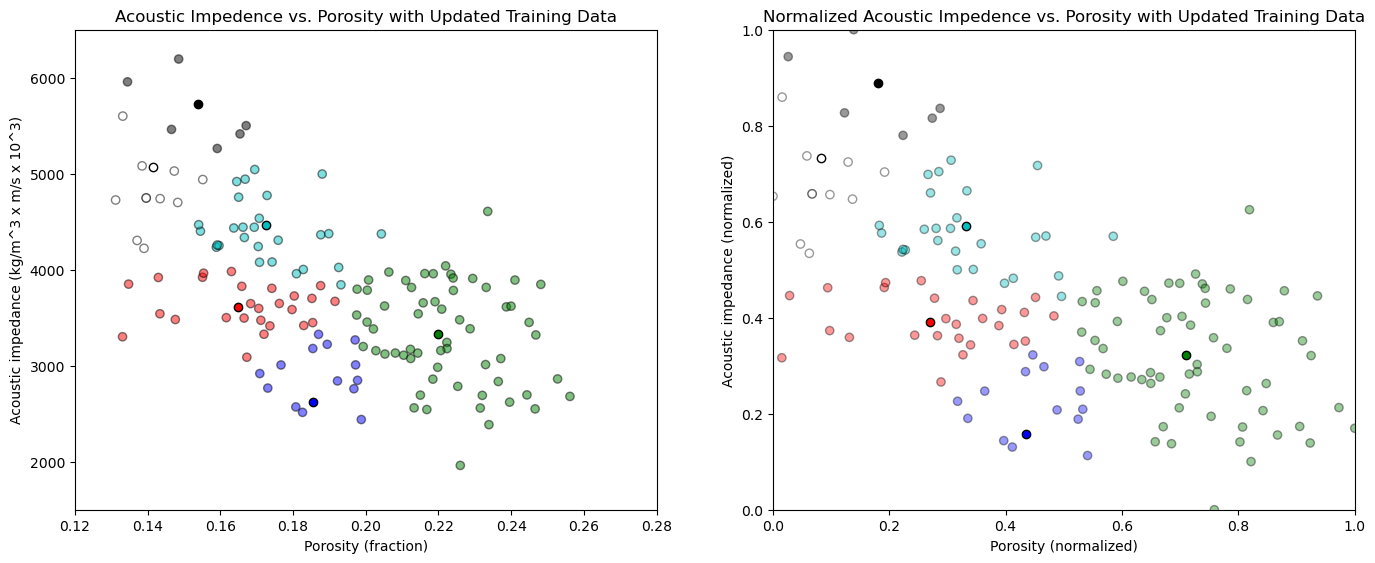

In [14]:
df = assignment(df, centroids)

plt.subplot(121)                          # plot the assigned training data and K prototypes
plt.scatter(df['Porosity'], df['AI'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(centroids.get(i)[0], centroids.get(i)[1], color=colmap[i],linewidths=1.0, edgecolors="black")
plt.title('Acoustic Impedence vs. Porosity with Updated Training Data'); plt.xlabel('Porosity (fraction)'); plt.ylabel('Acoustic impedance (kg/m^3 x m/s x 10^3)')
plt.xlim(por_min, por_max)
plt.ylim(AI_min, AI_max)

plt.subplot(122)                          # plot the training data and K prototypes
plt.scatter(df_subset['Norm_Porosity'], df['Norm_AI'], c=df['color'], alpha = 0.4, linewidths=1.0, edgecolors="black")
for i in centroids.keys():
    plt.scatter(centroids.get(i)[2], centroids.get(i)[3], color=colmap[i],linewidths=1.0, edgecolors="black")
plt.title('Normalized Acoustic Impedence vs. Porosity with Updated Training Data'); plt.xlabel('Porosity (normalized)'); plt.ylabel('Acoustic impedance (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

#### Iterate Until Convergence 

Now we interate over the the previous set of steps:

* assign the training data to the nearest prototype

* update the prototypes 

We do this until there is no further chance in the category assigned to each of the training data.

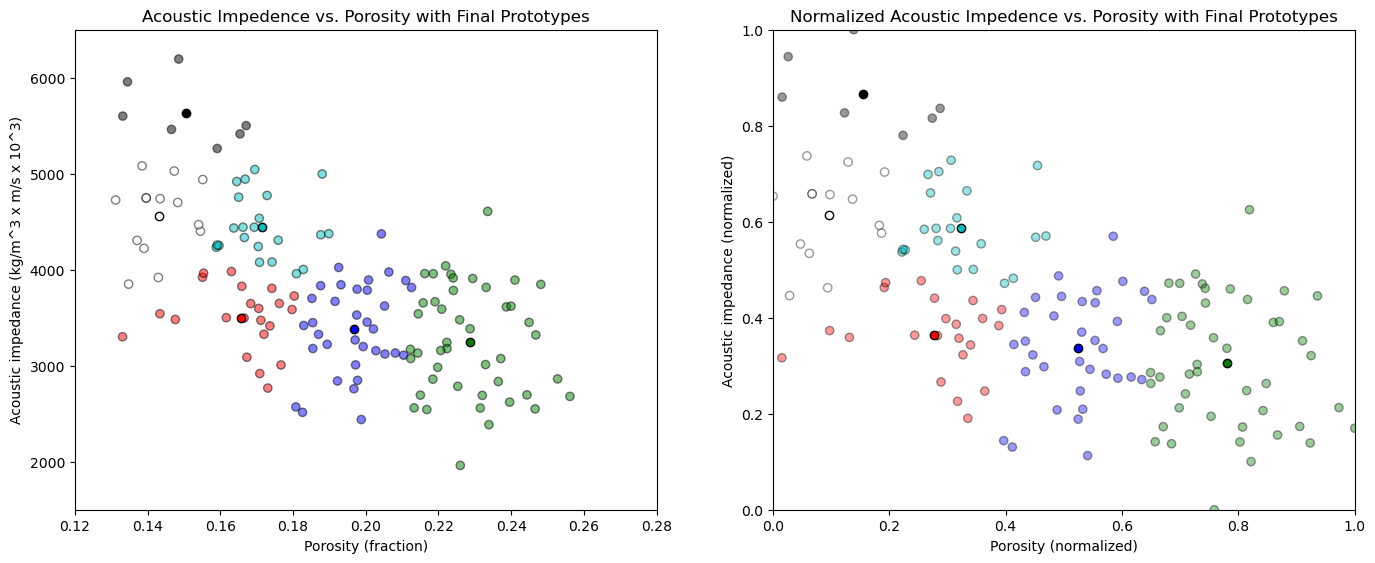

In [15]:
# Continue until all assigned categories don't change any more (code modified from Ben Keen, http://benalexkeen.com/k-means-clustering-in-python/)

while True:
    closest_centroids = df['closest'].copy(deep=True)
    centroids = update(centroids,pormin,pormax,AImin,AImax)
    df = assignment(df, centroids)
    if closest_centroids.equals(df['closest']):
        break

plt.subplot(121)                          # plot the assigned training data and K prototypes
plt.scatter(df['Porosity'], df['AI'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(centroids.get(i)[0], centroids.get(i)[1], color=colmap[i],linewidths=1.0, edgecolors="black")
plt.title('Acoustic Impedence vs. Porosity with Final Prototypes'); plt.xlabel('Porosity (fraction)'); plt.ylabel('Acoustic impedance (kg/m^3 x m/s x 10^3)')
plt.xlim(por_min, por_max)
plt.ylim(AI_min, AI_max)

plt.subplot(122)                          # plot the training data and K prototypes
plt.scatter(df_subset['Norm_Porosity'], df['Norm_AI'], c=df['color'], alpha = 0.4, linewidths=1.0, edgecolors="black")
for i in centroids.keys():
    plt.scatter(centroids.get(i)[2], centroids.get(i)[3], color=colmap[i],linewidths=1.0, edgecolors="black")
plt.title('Normalized Acoustic Impedence vs. Porosity with Final Prototypes'); plt.xlabel('Porosity (normalized)'); plt.ylabel('Acoustic impedance (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

#### Comments

There are so many more tests that one could attempt to gain experience with K-means clustering. I'll end here for brevity, but I invite you to continue. Consider, on your own:

* change the number of $K$ prototypes

* apply the original data (no normalization)

* apply other data sets 

* attempting methods with supervised K-means classification.  

<i>&copy; Copyright daytum 2025. All Rights Reserved</i>